
# What is Serial Dependence? #

In earlier lessons, we investigated properties of time series that were most easily modeled as *time dependent* properties, that is, with features we could derive directly from the time index. Some time series properties, however, can only be modeled as *serially dependent* properties, that is, using as features past values of the target series. The structure of these time series may not be apparent from a plot over time; plotted against past values, however, the structure becomes clear -- as we see in the figure below below.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/X0sSnwp.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>These two series have serial dependence, but not time dependence. Points on the right have coordinates <code>(value at time t-1, value at time t)</code>.
</center></figcaption>
</figure>

With trend and seasonality, we trained models to fit curves to plots like those on the left in the figure above -- the models were learning time dependence. The goal in this lesson is to train models to fit curves to plots like those on the right -- we want them to learn serial dependence.

### Cycles

One especially common way for serial dependence to manifest is in **cycles**. Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself.  Cyclic behavior is characteristic of systems that can affect themselves or whose reactions persist over time. Economies, epidemics, animal populations, volcano eruptions, and similar natural phenomena often display cyclic behavior.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/CC3TkAf.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Four time series with cyclic behavior.
</center></figcaption>
</figure>

What distinguishes cyclic behavior from seasonality is that cycles are not necessarily time dependent, as seasons are. What happens in a cycle is less about the particular date of occurence, and more about what has happened in the recent past. The (at least relative) independence from time means that cyclic behavior can be much more irregular than seasonality.

# Lagged Series and Lag Plots #

To investigate possible serial dependence (like cycles) in a time series, we need to create "lagged" copies of the series. **Lagging** a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time.

This shows the monthly unemployment rate in the US (`y`) together with its first and second lagged series (`y_lag_1` and `y_lag_2`, respectively). Notice how the values of the lagged series are shifted forward in time.

In [4]:

import pandas as pd

# Federal Reserve dataset: https://www.kaggle.com/federalreserve/interest-rates
reserve = pd.read_csv(
    "./data/ts-course-data/reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df.head()

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


By lagging a time series, we can make its past values appear contemporaneous with the values we are trying to predict (in the same row, in other words). This makes lagged series useful as features for modeling serial dependence. To forecast the US unemployment rate series, we could use `y_lag_1` and `y_lag_2` as features to predict the target `y`. This would forecast the future unemployment rate as a function of the unemployment rate in the prior two months.

### Lag plots

A **lag plot** of a time series shows its values plotted against its lags. Serial dependence in a time series will often become apparent by looking at a lag plot. We can see from this lag plot of *US Unemployment* that there is a strong and apparently linear relationship between the current unemployment rate and past rates.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Hvrboya.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Lag plot of US Unemployment with autocorrelations indicated.
</center></figcaption>
</figure>

The most commonly used measure of serial dependence is known as **autocorrelation**, which is simply the correlation a time series has with one of its lags. *US Unemployment* has an autocorrelation of 0.99 at lag 1, 0.98 at lag 2, and so on.

### Choosing lags

When choosing lags to use as features, it generally won't be useful to include *every* lag with a large autocorrelation. In *US Unemployment*, for instance, the autocorrelation at lag 2 might result entirely from "decayed" information from lag 1 -- just correlation that's carried over from the previous step. If lag 2 doesn't contain anything new, there would be no reason to include it if we already have lag 1.

The **partial autocorrelation** tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes, so to speak. Plotting the partial autocorrelation can help you choose which lag features to use. In the figure below, lag 1 through lag 6 fall outside the intervals of "no correlation" (in blue), so we might choose lags 1 through lag 6 as features for *US Unemployment*. (Lag 11 is likely a false positive.)

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/6nTe94E.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Partial autocorrelations of US Unemployment through lag 12 with 95% confidence intervals of no correlation.
</center></figcaption>
</figure>

A plot like that above is known as a *correlogram*. The correlogram is for lag features essentially what the periodogram is for Fourier features.

Finally, we need to be mindful that autocorrelation and partial autocorrelation are measures of *linear* dependence. Because real-world time series often have substantial non-linear dependences, it's best to look at a lag plot (or use some more general measure of dependence, like [mutual information](https://www.kaggle.com/ryanholbrook/mutual-information)) when choosing lag features. The *Sunspots* series has lags with non-linear dependence which we might overlook with autocorrelation.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Q38UVOu.png" width=350, alt="">
    <figcaption style="textalign: center; font-style: italic"><center>Lag plot of the <em>Sunspots</em> series.
</center></figcaption>
</figure>

Non-linear relationships like these can either be transformed to be linear or else learned by an appropriate algorithm.

# Example - Flu Trends #

The *Flu Trends* dataset contains records of doctor's visits for the flu for weeks between 2009 and 2016. Our goal is to forecast the number of flu cases for the coming weeks.

We will take two approaches. In the first we'll forecast doctor's visits using lag features. Our second approach will be to forecast doctor's visits using lags of *another* set of time series: flu-related search terms as captured by Google Trends.

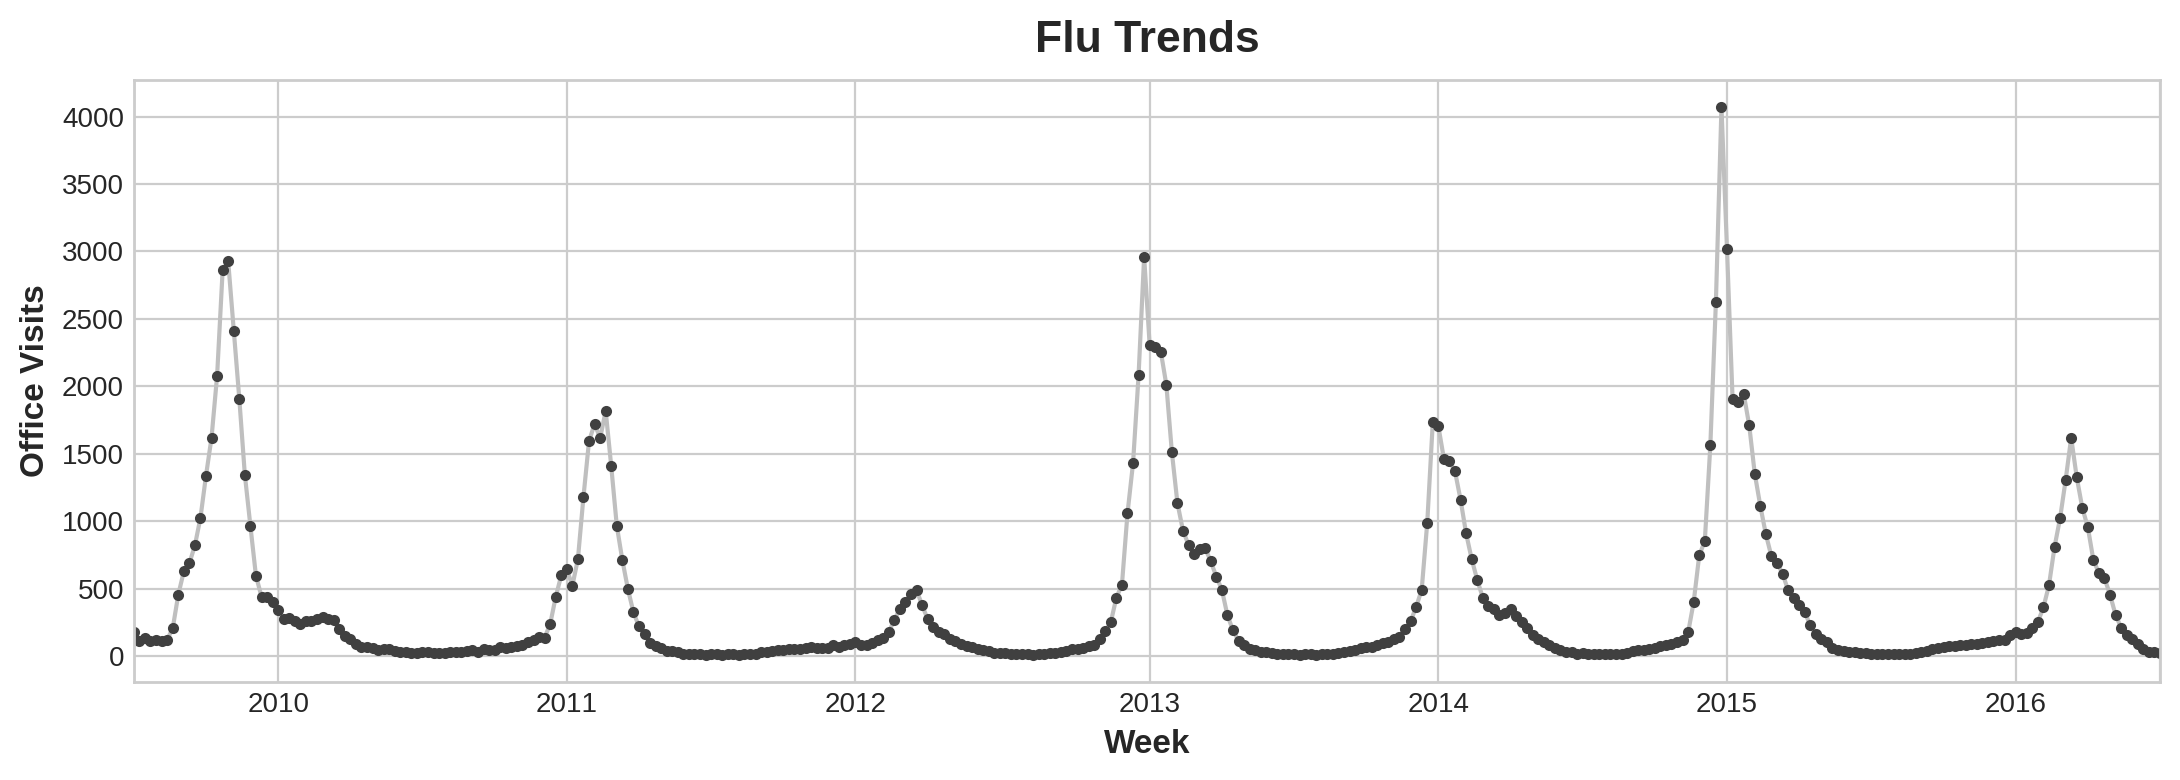

In [5]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


data_dir = Path("./data/ts-course-data/")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")

Our *Flu Trends* data shows irregular cycles instead of a regular seasonality: the peak tends to occur around the new year, but sometimes earlier or later, sometimes larger or smaller. Modeling these cycles with lag features will allow our forecaster to react dynamically to changing conditions instead of being constrained to exact dates and times as with seasonal features.

Let's take a look at the lag and autocorrelation plots first:

In [6]:
flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


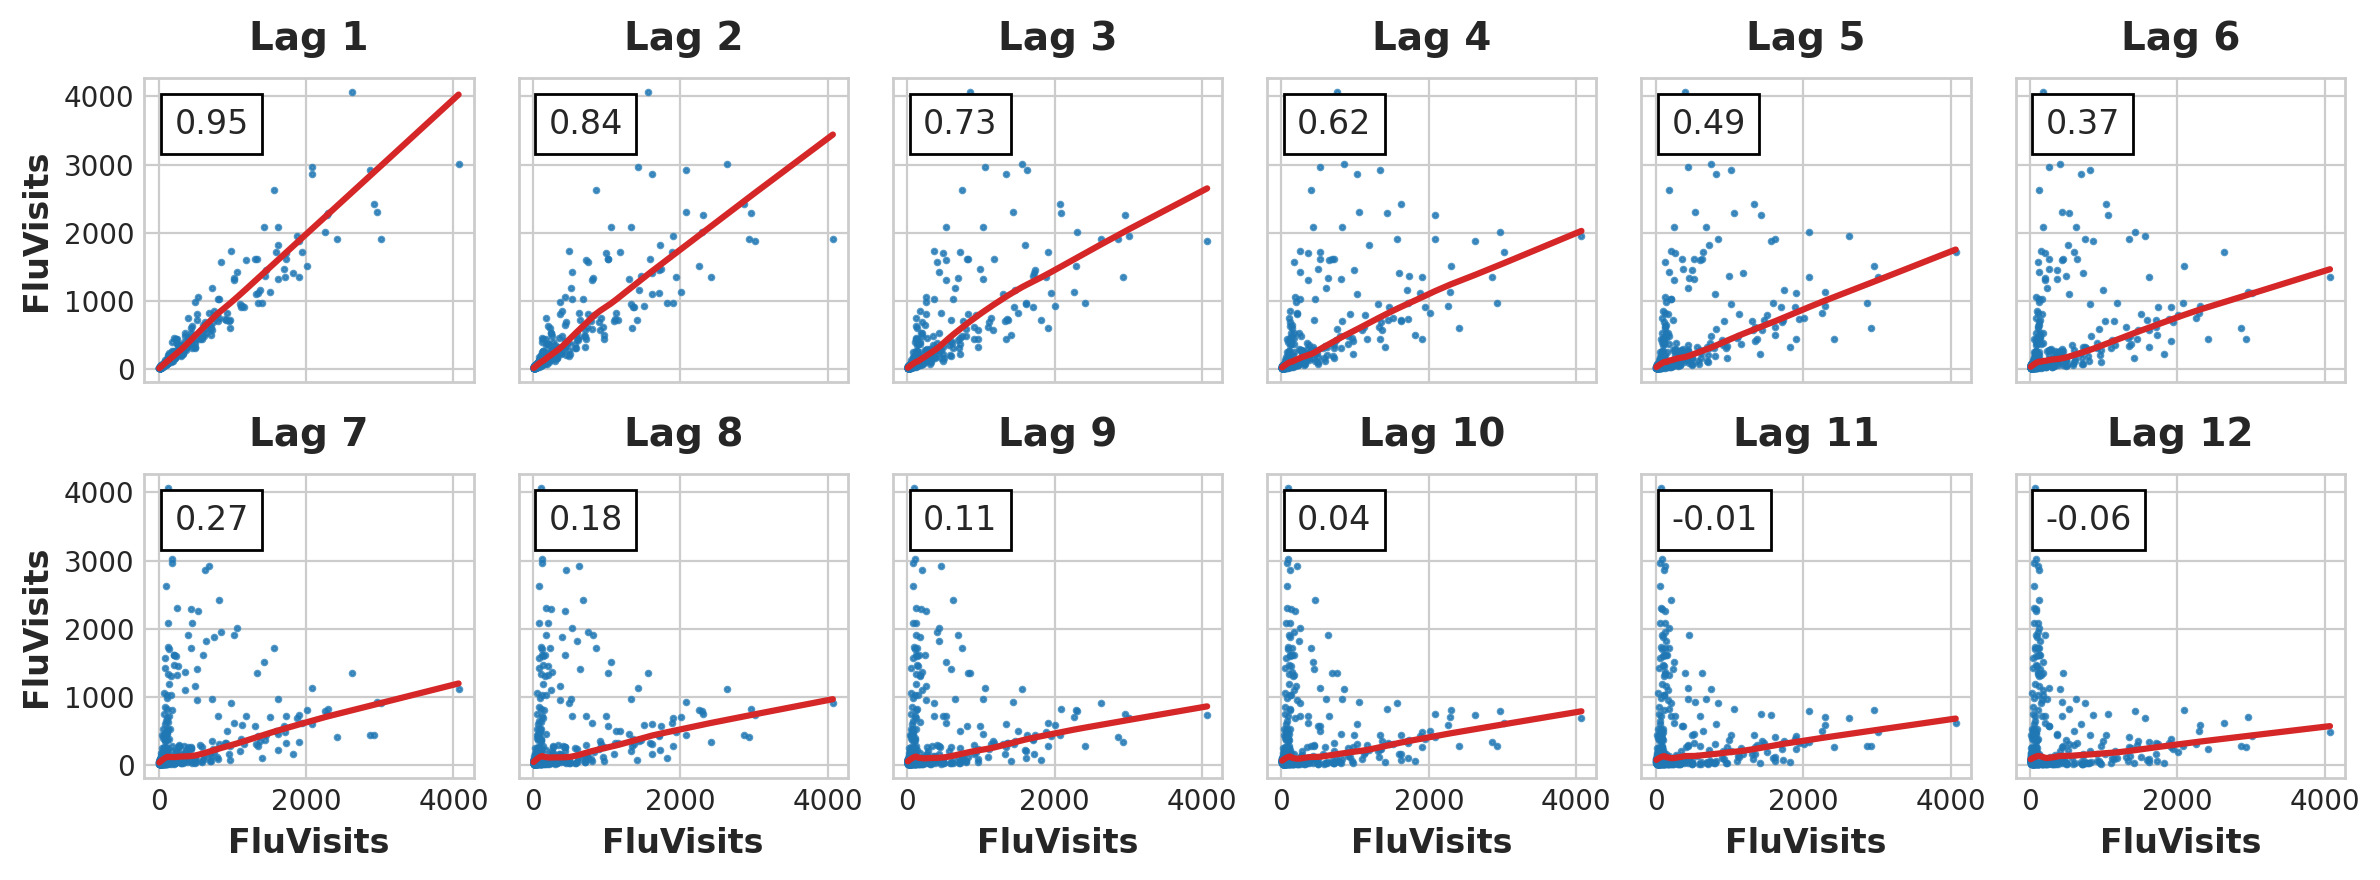

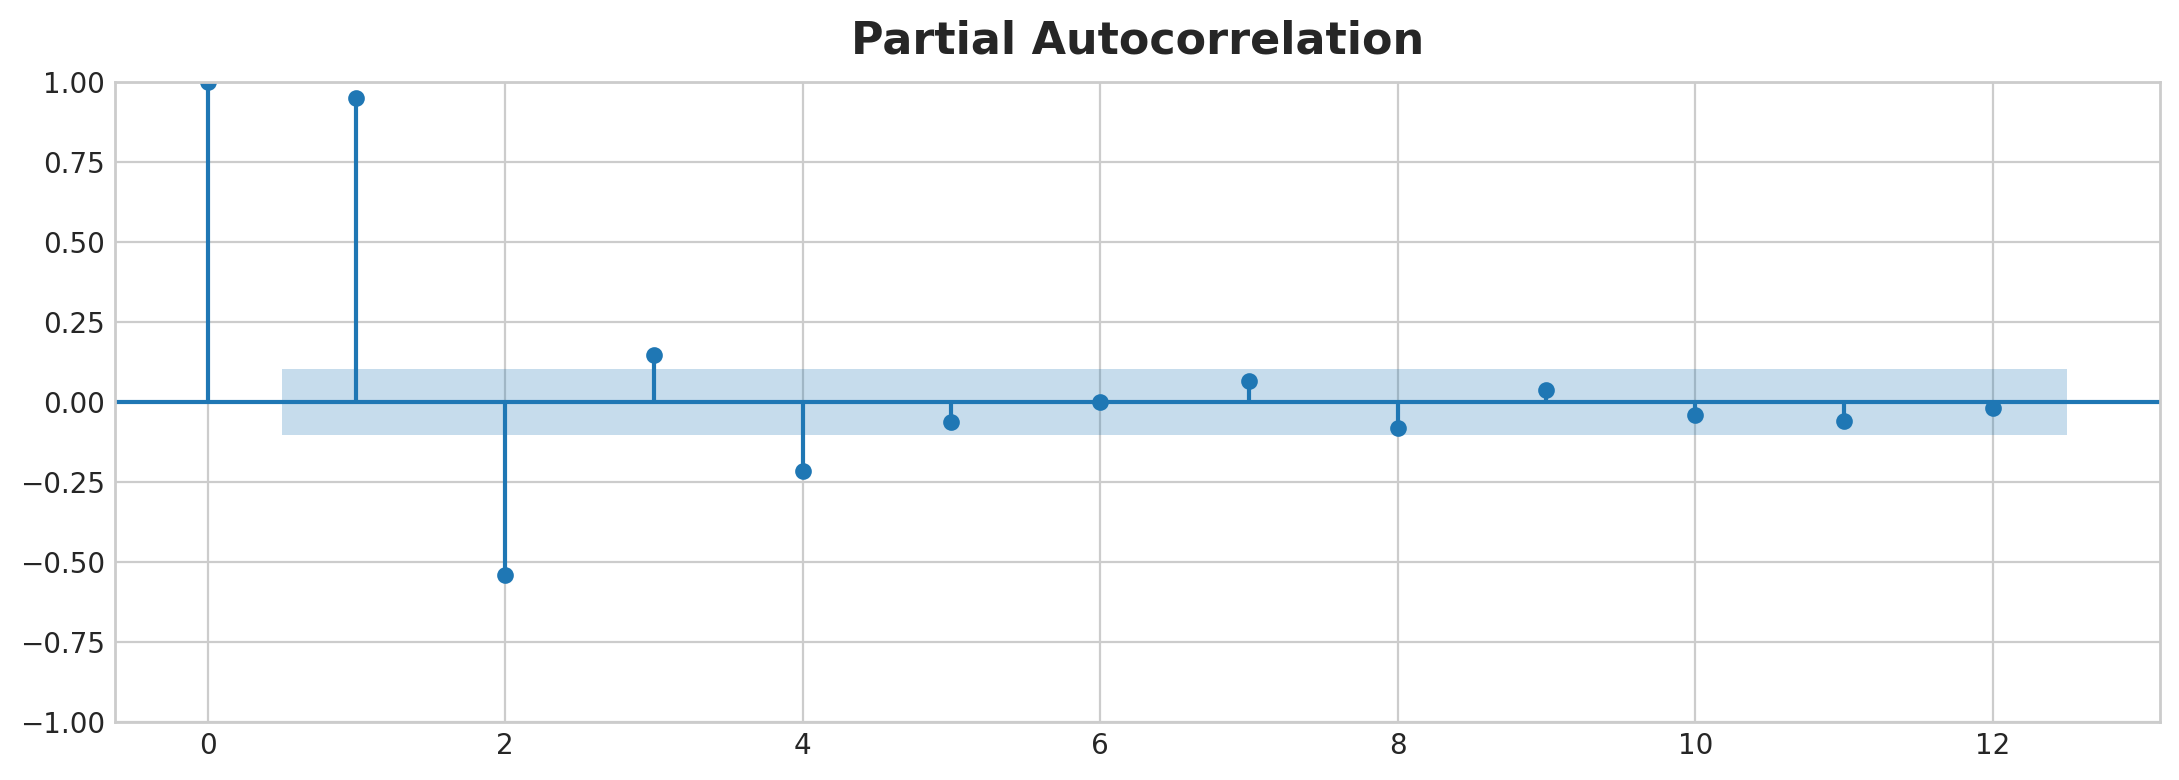

In [3]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

The lag plots indicate that the relationship of `FluVisits` to its lags is mostly linear, while the partial autocorrelations suggest the dependence can be captured using lags 1, 2, 3, and 4. We can lag a time series in Pandas with the `shift` method. For this problem, we'll fill in the missing values the lagging creates with `0.0`.

In [12]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

In previous lessons, we were able to create forecasts for as many steps as we liked beyond the training data. When using lag features, however, we are limited to forecasting time steps whose lagged values are available. Using a lag 1 feature on Monday, we can't make a forecast for Wednesday because the lag 1 value needed is Tuesday which hasn't happened yet.

We'll see strategies for handling this problem in Lesson 6. For this example, we'll just use a values from a test set.

In [15]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

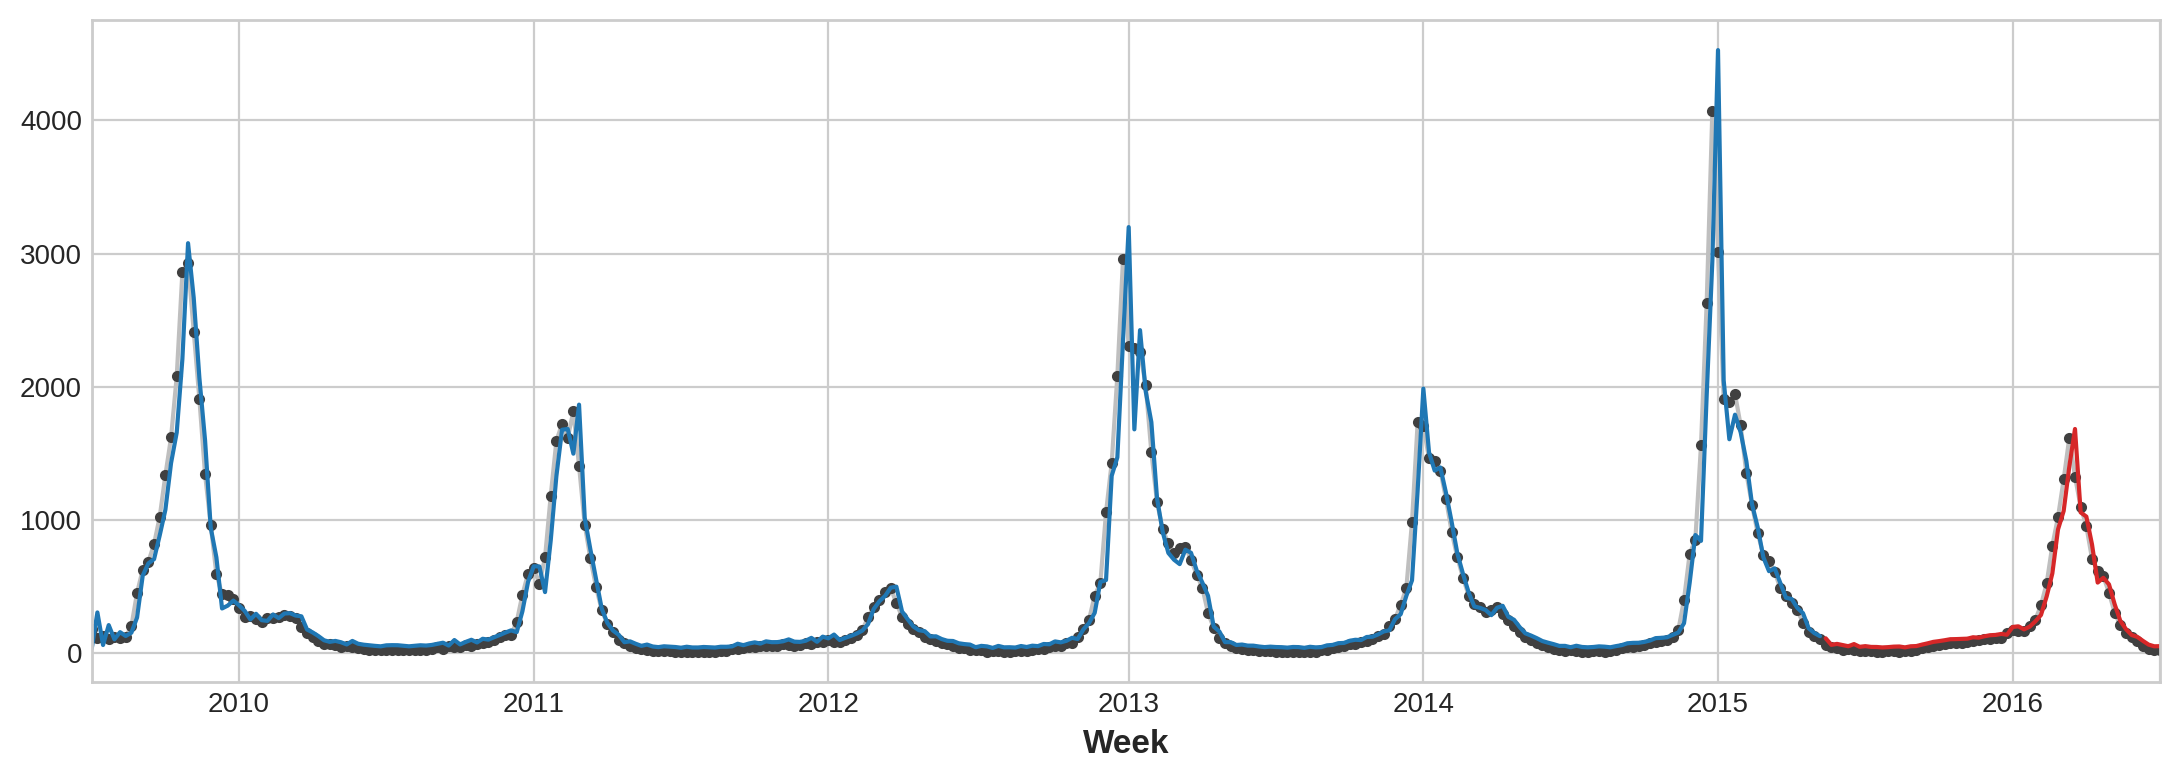

In [16]:

ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

---

Looking just at the forecast values, we can see how our model needs a time step to react to sudden changes in the target series. This is a common limitation of models using only lags of the target series as features.

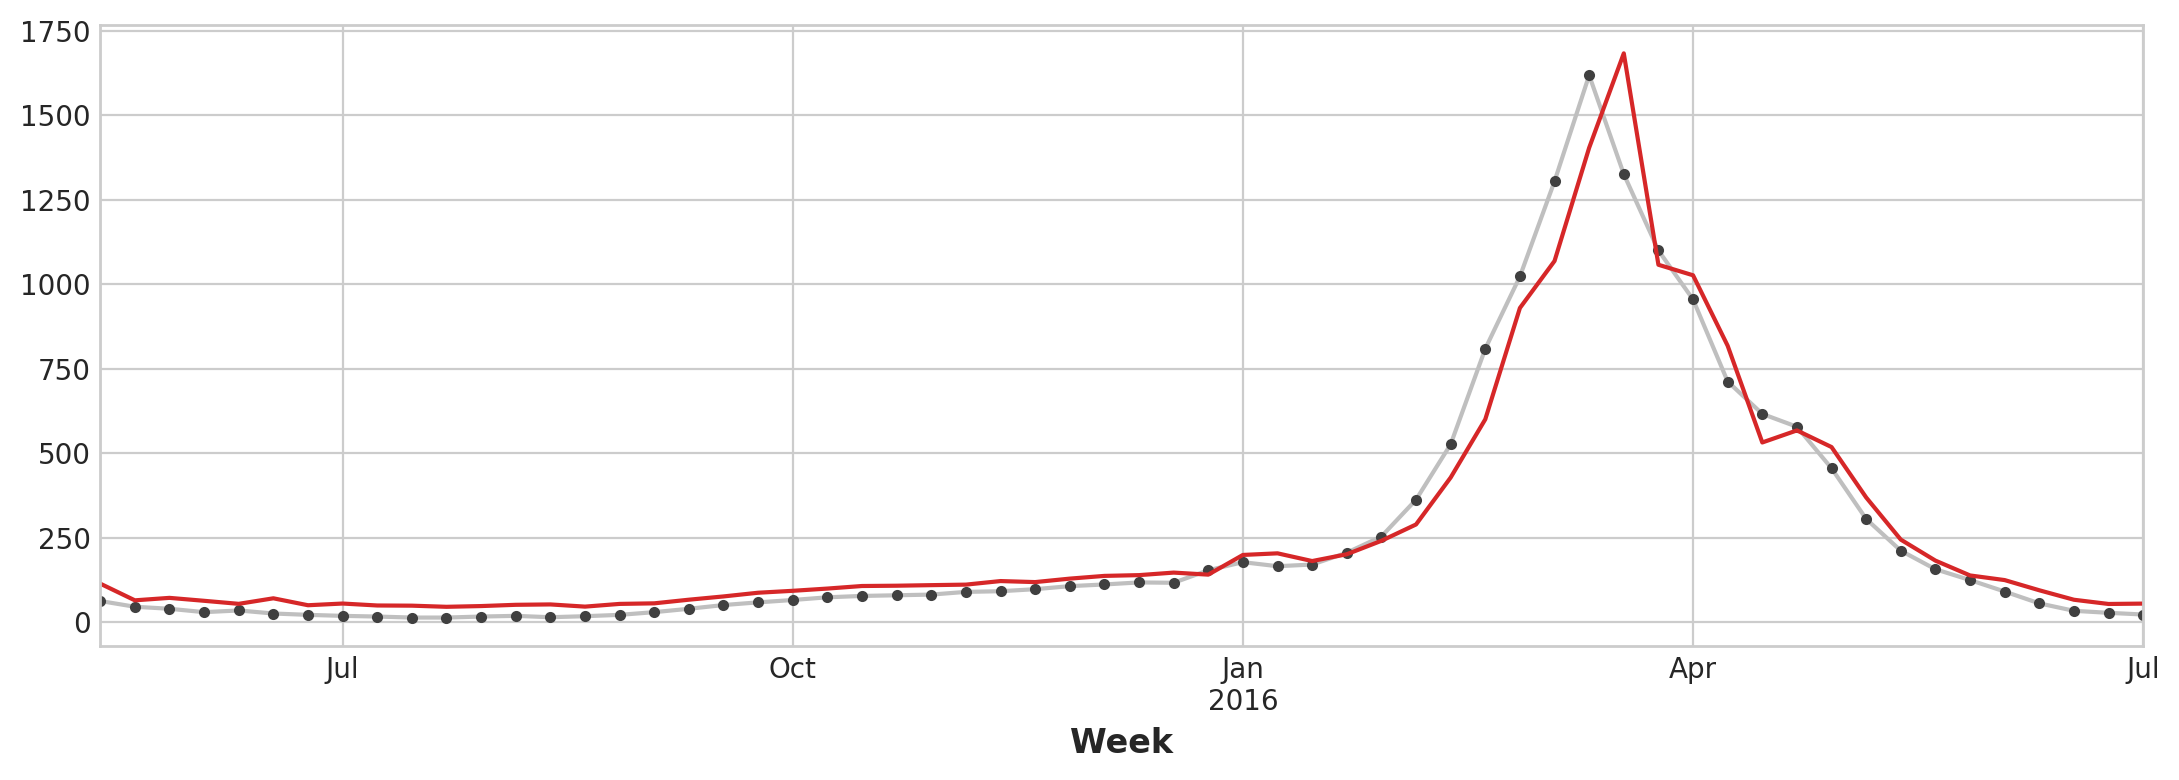

In [7]:

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

To improve the forecast we could try to find *leading indicators*, time series that could provide an "early warning" for changes in flu cases. For our second approach then we'll add to our training data the popularity of some flu-related search terms as measured by Google Trends.

Plotting the search phrase `'FluCough'` against the target `'FluVisits'` suggests such search terms could be useful as leading indicators: flu-related searches tend to become more popular in the weeks prior to office visits.

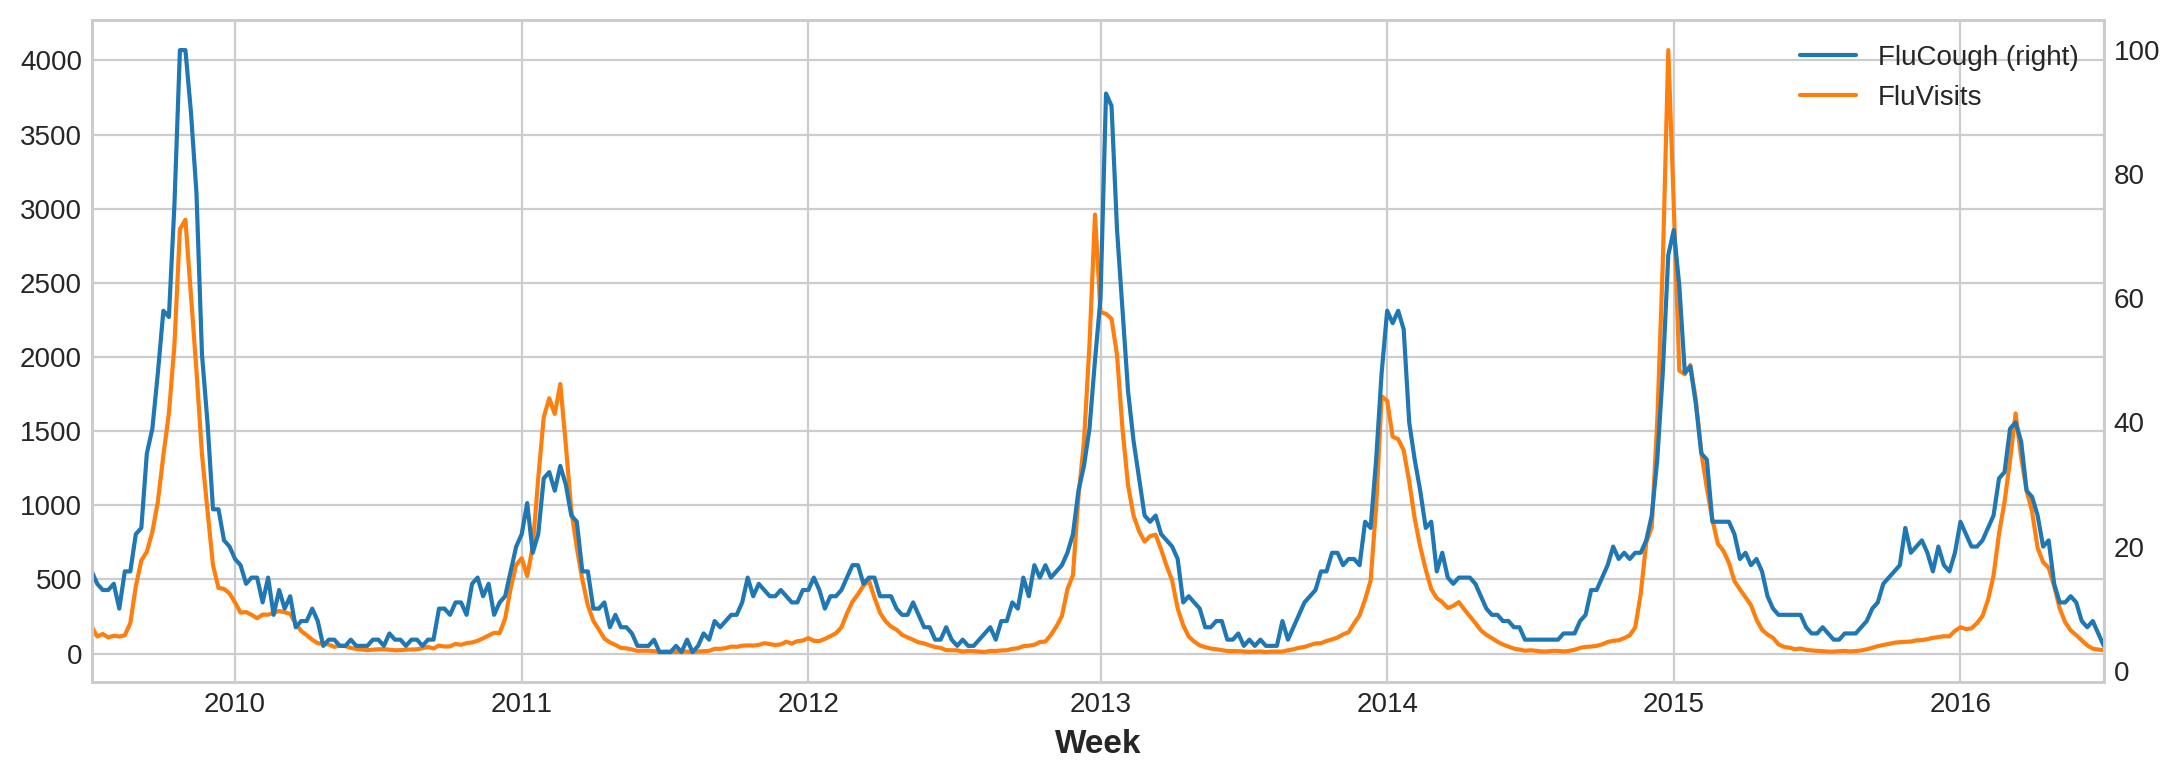

In [17]:

ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

The dataset contains 129 such terms, but we'll just use a few.

In [18]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0 = make_lags(flu_trends[search_terms], lags=3)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]

# Create four lags for the target, as before
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

In [19]:
X.head()

,y_lag_1 FluContagious,y_lag_1 FluCough,y_lag_1 FluFever,y_lag_1 InfluenzaA,y_lag_1 TreatFlu,y_lag_1 IHaveTheFlu,y_lag_1 OverTheCounterFlu,y_lag_1 HowLongFlu,y_lag_2 FluContagious,y_lag_2 FluCough,...,y_lag_3 FluFever,y_lag_3 InfluenzaA,y_lag_3 TreatFlu,y_lag_3 IHaveTheFlu,y_lag_3 OverTheCounterFlu,y_lag_3 HowLongFlu,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,5.0,16.0,15.0,36.0,6.0,5.0,11.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,6.0,14.0,15.0,25.0,12.0,7.0,7.0,7.0,5.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,6.0,13.0,13.0,24.0,8.0,8.0,7.0,7.0,6.0,14.0,...,15.0,36.0,6.0,5.0,11.0,6.0,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,5.0,13.0,12.0,23.0,5.0,4.0,6.0,6.0,6.0,13.0,...,15.0,25.0,12.0,7.0,7.0,7.0,109.0,132.0,115.0,180.0


Our forecasts are a bit rougher, but our model appears to be better able to anticipate sudden increases in flu visits, suggesting that the several time series of search popularity were indeed effective as leading indicators.

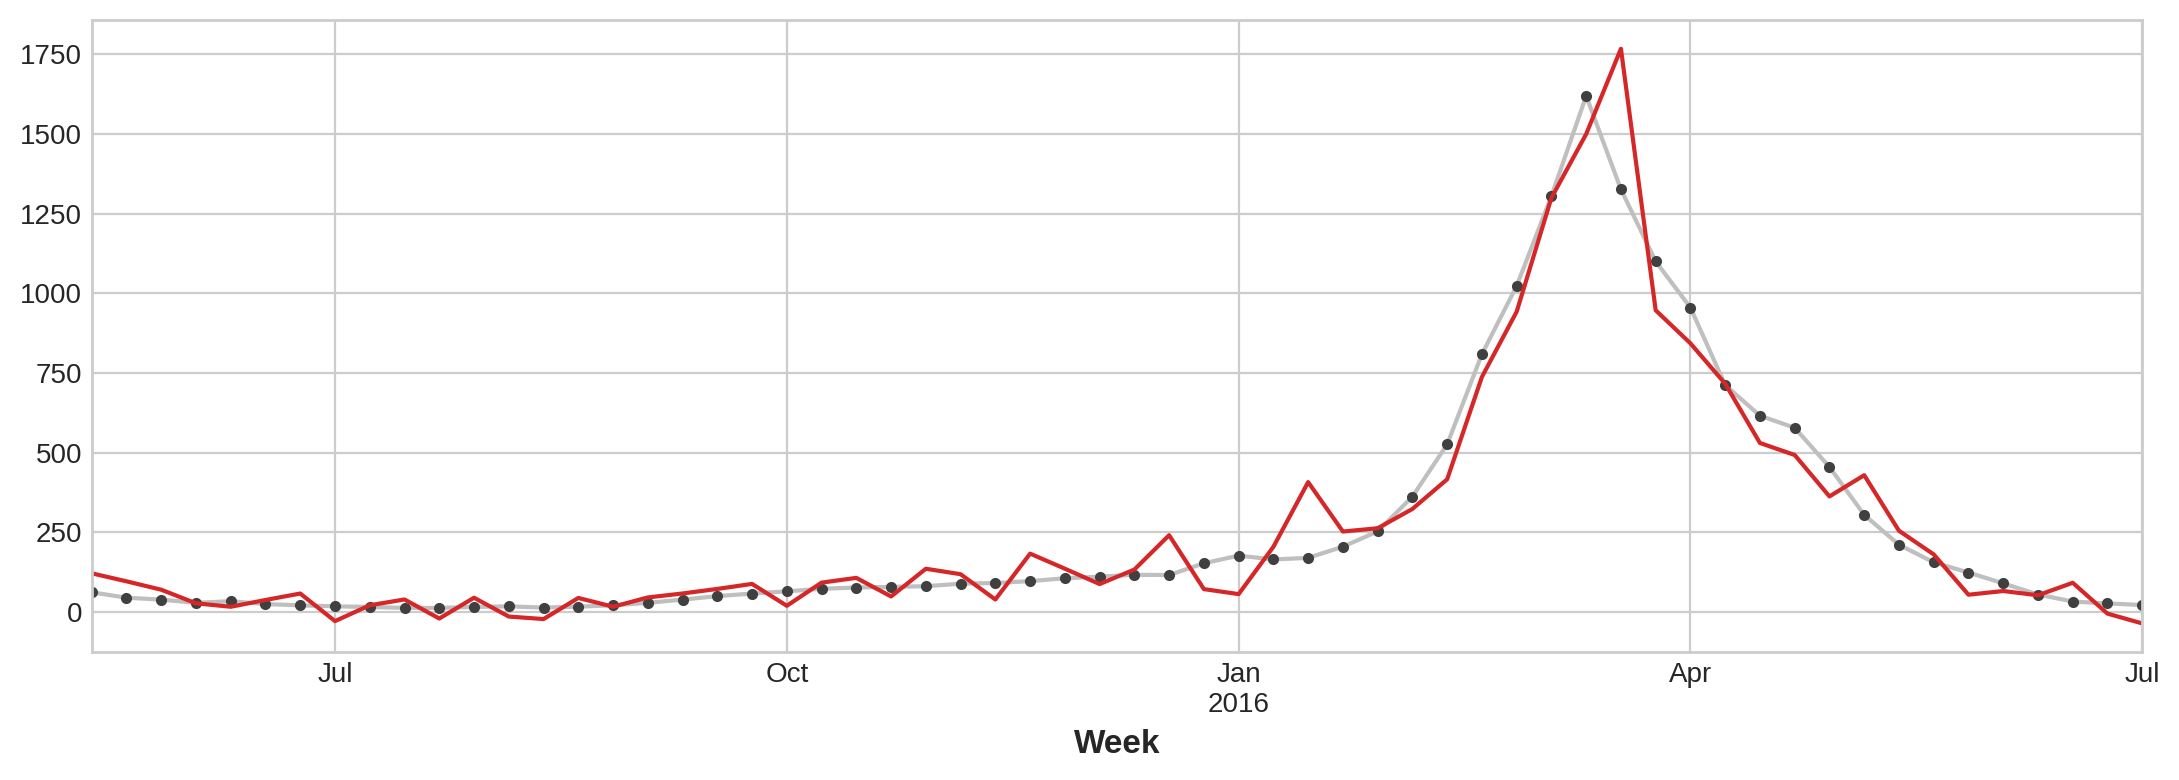

In [20]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

---

The time series illustrated in this lesson are what you might call "purely cyclic": they have no obvious trend or seasonality. It's not uncommon though for time series to possess trend, seasonality, and cycles -- all three components at once. You could model such series with linear regression by just adding the appropriate features for each component. You can even combine models trained to learn the components separately, which we'll learn how to do in the next lesson with *forecasting hybrids*.

# Your Turn #

[**Create lag features for Store Sales**](https://www.kaggle.com/kernels/fork/19616002) and explore other kinds of time series features.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*